Burcu Eren

In [5]:
import pandas as pd


In [6]:
from datetime import datetime
def date_parser(d):
    return datetime.strptime(d,'%Y-%m-%d %H:%M:%S')

In [3]:
csv = pd.read_csv('taxi-trips.xls')

FileNotFoundError: File b'taxi-trips.xls' does not exist

In [4]:
csv.pickup_datetime = csv.pickup_datetime.apply(date_parser) 
csv.dropoff_datetime = csv.dropoff_datetime.apply(date_parser) 

NameError: name 'csv' is not defined

Geocoding
----

In [44]:
import reverse_geocoder
points = [(x,y) for x,y in zip(csv.pickup_latitude,csv.pickup_longitude)] +  [
    (x,y) for x,y in zip(csv.dropoff_latitude,csv.dropoff_longitude)]
codes = [p['name'] for p in reverse_geocoder.search(points)]

l = len(csv.pickup_latitude.tolist());

csv['pickup_district'] = codes[:l]
csv['dropoff_district'] = codes[l:]

In [ ]:
csv.set_index('Date', inplace=True)
csv['adj_close'].plot()

Common Locations
-----

Manhattan           45329
New York City       34625
Long Island City    17787
Weehawken           11334
The Bronx            2777
Name: pickup_district, dtype: int64


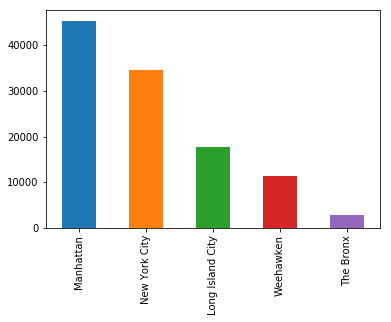

In [103]:
counts = csv.pickup_district.value_counts()
print(counts[:5])
counts[:5].plot(kind="bar")

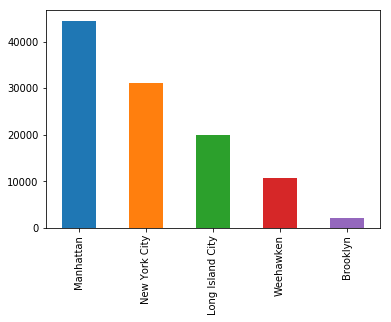

In [104]:
counts = csv.dropoff_district.value_counts()
counts[:5]
counts[:5].plot(kind="bar")

Geographic Distance using Geopy's great circle distance

In [63]:
from geopy.distance import great_circle
dist = []
for i,j in zip(
                zip(csv.pickup_latitude, 
                    csv.pickup_longitude),
                zip(csv.dropoff_latitude, 
                    csv.dropoff_longitude)):
    dist += [great_circle(i,j).kilometers]

csv['distance'] = dist

Time of the day convertion using function apply of pandas

In [98]:
import datetime
def timeday(time):
    hour = time.hour
    if hour < 7:
        return "latenight"
    elif hour < 9:
        return "rushhourmorning"
    elif hour < 16:
        return "afternoon"
    elif hour < 18:
        return "rushhourevening"
    elif hour < 23:
        return "evening"
    else:
        return "latenight"
csv['time-of-the-day'] = csv.pickup_datetime.apply(timeday)


Duration is calculated using datetime difference, stored as seconds between pickup and dropoff

In [65]:
csv['duration'] = csv.dropoff_datetime-csv.pickup_datetime

In [66]:
csv['duration-in-secs'] = csv['duration'].apply(lambda x:x.total_seconds())

Time of day average distance 

                 distance
time-of-the-day          
afternoon        3.108522
evening          3.377202
latenight        4.116267
rushhourevening  3.341173
rushhourmorning  3.126970


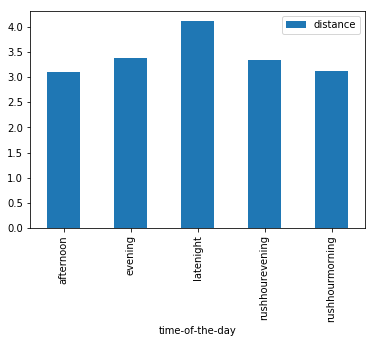

In [105]:
avg_dist = csv[['distance','time-of-the-day']].groupby(['time-of-the-day']).mean()
print(avg_dist)
avg_dist.plot(kind="bar")

Time of day, average duration in taxi

                 duration-in-secs
time-of-the-day                  
afternoon               16.065379
evening                 14.893255
latenight               14.434924
rushhourevening         17.074909
rushhourmorning         15.308145


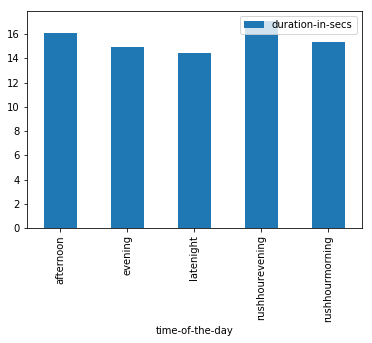

In [106]:
avg_time = csv[['duration-in-secs','time-of-the-day']].groupby(['time-of-the-day']).mean()/60.0
print(avg_time)
avg_time.plot(kind="bar")

Hypothesis testing
-----
check if single and multi passengers have same distance distribution by ttest

In [94]:
import scipy.stats
def only1(a):
    return a==1

singlepassenger = csv[csv.passenger_count.apply(only1)]
multipassenger = csv[csv.passenger_count.apply(only1)==False]

print("single:",singlepassenger.distance.mean())
print("multiple:",multipassenger.distance.mean())

mytest = scipy.stats.ttest_ind(singlepassenger.distance, multipassenger.distance)

if mytest.pvalue < 0.05:
    print ('Reject Null!')
else:
    print ('Null')

single: 3.361044308217033
multiple: 3.484480598809778
Reject Null!


check if weekend and week days have same distance distribution by ttest

In [97]:
import scipy.stats
def day(a):
    name = a.strftime("%A")
    return name=="Sunday" or name =="Saturday"

weekend = csv[csv.pickup_datetime.apply(day)]
week = csv[csv.pickup_datetime.apply(day)==False]

print("week days:",week.distance.mean())
print("weekend:",weekend.distance.mean())

mytest = scipy.stats.ttest_ind(week.distance, weekend.distance)

if mytest.pvalue < 0.05:
    print ('Reject Null!')
else:
    print ('Null')

week days: 3.3557277437937825
weekend: 3.4943522536745344
Reject Null!
